In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [2]:
credit_card_data=pd.read_csv(r"C:\Users\Midun\Downloads\fraud detection\fraudTrain.csv", parse_dates=['trans_date_trans_time'])
credit_card_data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [3]:
credit_card_data.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [4]:
credit_card_data['hour']=credit_card_data.trans_date_trans_time.dt.hour

In [5]:
credit_card_data['hourEnc']=0
credit_card_data.loc[credit_card_data.hour <5,'hourEnc']=1
credit_card_data.loc[credit_card_data.hour >21,'hourEnc']=1

In [6]:
credit_card_data['trans_date_trans_time']=pd.to_datetime(credit_card_data['trans_date_trans_time'])

credit_card_data.sort_values(by='trans_date_trans_time', inplace=True)

credit_card_data['transaction_last_1d']=credit_card_data['trans_date_trans_time'].rolling(window=1).count()

credit_card_data['transaction_last_7d']=credit_card_data['trans_date_trans_time'].rolling(window=7).count()

credit_card_data['transaction_last_30d']=credit_card_data['trans_date_trans_time'].rolling(window=30).count()

credit_card_data['transaction_last_1d'].fillna(0,inplace=True)
credit_card_data['transaction_last_7d'].fillna(0,inplace=True)
credit_card_data['transaction_last_30d'].fillna(0,inplace=True)

In [7]:
credit_card_data['trans_date_trans_time']=pd.to_datetime(credit_card_data['trans_date_trans_time'])
def last1DayTransactionCount(group):
    return group['trans_date_trans_time'].rolling(window=1).count()
def last7DayTransactionCount(group):
    return group['trans_date_trans_time'].rolling(window=7).count()
def last30DayTransactionCount(group):
    return group['trans_date_trans_time'].rolling(window=30).count()
df1=credit_card_data.groupby('cc_num').apply(last1DayTransactionCount)

df1=credit_card_data.groupby('cc_num').apply(last7DayTransactionCount)

df1=credit_card_data.groupby('cc_num').apply(last30DayTransactionCount)

df1=df1.reset_index(level=0,drop=True)

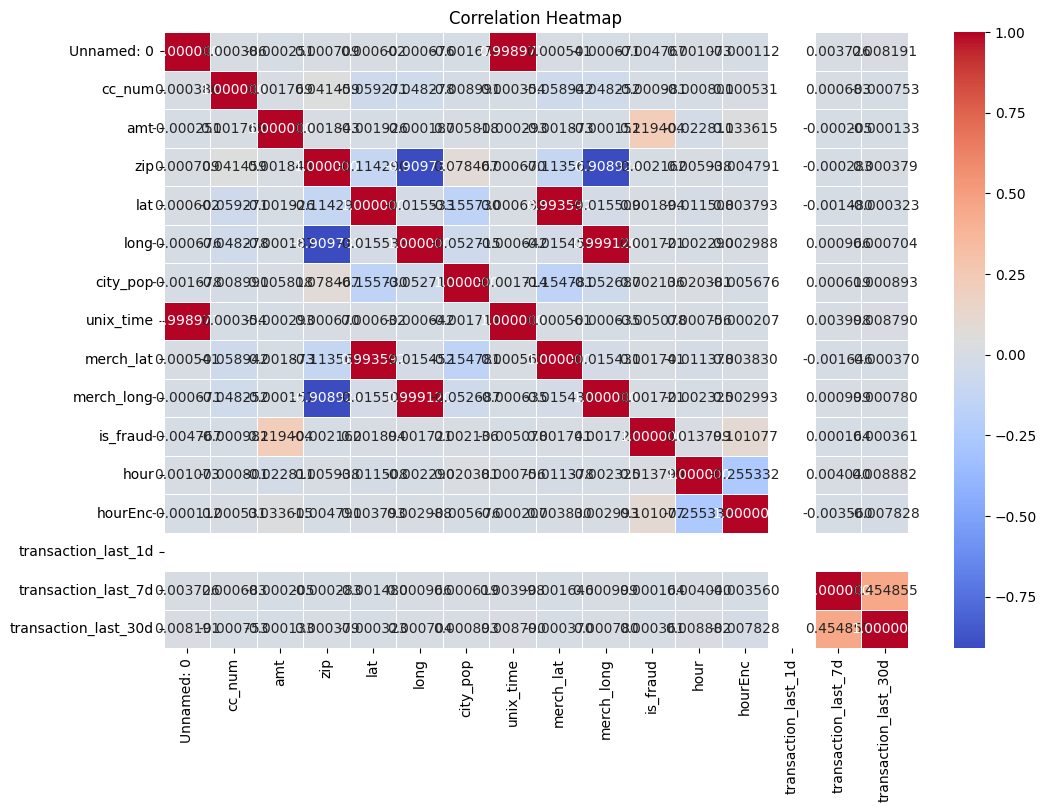

In [8]:
numeric_data = credit_card_data.select_dtypes(include=['number'])

correlation_matrix=numeric_data.corr()

plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True,  cmap='coolwarm',fmt='2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [9]:
numeric_columns = credit_card_data.select_dtypes(include='number')
fraud_correlation = numeric_columns.corr()['is_fraud'].abs().sort_values(ascending=False)

print(fraud_correlation)

is_fraud                1.000000
amt                     0.219404
hourEnc                 0.101077
hour                    0.013799
unix_time               0.005078
Unnamed: 0              0.004767
zip                     0.002162
city_pop                0.002136
lat                     0.001894
merch_lat               0.001741
merch_long              0.001721
long                    0.001721
cc_num                  0.000981
transaction_last_30d    0.000361
transaction_last_7d     0.000164
transaction_last_1d          NaN
Name: is_fraud, dtype: float64


In [10]:
train_data = pd.read_csv(r"C:\Users\Midun\Downloads\fraud detection\fraudTrain.csv")
test_data = pd.read_csv(r"C:\Users\Midun\Downloads\fraud detection\fraudTest.csv")

numeric_columns_train = train_data.select_dtypes(include='number')

numeric_columns_test = test_data.select_dtypes(include='number')

X_train = numeric_columns_train.drop(['is_fraud'], axis=1)
y_train = train_data['is_fraud']

X_test = numeric_columns_test.drop(['is_fraud'],axis=1)
y_test = test_data['is_fraud']

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test,y_pred)

print(f"Accuracy :{accuracy}")
print(f"Confusion Matrix :\n{conf_matrix}")
print(f"Classification Report :\n{classification_rep}")

Accuracy :0.9954797298634742
Confusion Matrix :
[[553207    367]
 [  2145      0]]
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.00      0.00      0.00      2145

    accuracy                           1.00    555719
   macro avg       0.50      0.50      0.50    555719
weighted avg       0.99      1.00      0.99    555719

